<a href="https://colab.research.google.com/github/jinseonggram/Korean-MRC/blob/master/kobigbird_v1_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving test.json to test.json
Saving train.json to train.json


In [2]:
!pip install awscli
! apt-get install -y openjdk-8-jdk python3-dev
! pip install konlpy "tweepy<4.0.0"
! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.9 MB 27.7 MB/s 
     |████████████████████████████████| 79 kB 9.6 MB/s 
     |████████████████████████████████| 9.3 MB 77.2 MB/s 
     |████████████████████████████████| 548 kB 89.7 MB/s 
     |████████████████████████████████| 636 kB 97.9 MB/s 
     |████████████████████████████████| 140 kB 81.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: docutils
    Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 27.9 MB/s 
     |████████████████████████████████| 7.6 MB 70.5 MB/s 
     |████████████████████████████████| 163 kB 94.5 MB/s 


In [ ]:
# %pip install -q wandb

In [4]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Requirments

## Import

In [5]:
import os
import random
import math
import csv
import json
from statistics import mean
from typing import List, Tuple, Dict, Any
import uuid

from tqdm.notebook import tqdm
from easydict import EasyDict as edict

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# import wandb

import torch
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from torchinfo import summary

from transformers import ElectraModel, ElectraTokenizer, ElectraForQuestionAnswering, AutoModelForQuestionAnswering, AutoTokenizer, AutoConfig

In [ ]:
for name in 'models', 'submissions':
    os.makedirs(name, exist_ok=True)

# Set Arguments, Hyper-parameters

In [6]:
args = edict({'w_project': 'test_project',
              'w_entity': 'chohs1221',
              'learning_rate': 6e-5,
              'batch_size': {'train': 64,
                             'eval': 16,
                             'test': 64},
              'accumulate': 64,
              'epochs': 1,
              'seed': 42,
              # 'model_name': 'monologg/koelectra-base-v3-discriminator',
              # 'model_name': 'kykim/electra-kor-base',
              'model_name': 'monologg/kobigbird-bert-base',
              # 'model_name': 'skt/kobert-base-v1',
              # 'model_name': 'beomi/kcbert-large',
              # 'model_name': 'bert-large-uncased',
              # 'model_name': 'allenai/longformer-base-4096',
              'max_length': 2048})
# args['NAME'] = ''f'koelectra_ep{args.epochs}_lr{args.learning_rate}_{random.randrange(0, 1024)}'
args['NAME'] = ''f'kobigbird_ep{args.epochs}_max{args.max_length}_lr{args.learning_rate}_{random.randrange(0, 1024)}'
print(args.NAME)
print(args.model_name)

kobigbird_ep1_max2048_lr6e-05_406
monologg/kobigbird-bert-base


# Initialize

## Wandb

In [ ]:
# wandb.login()

In [ ]:
# wandb.init(project = args.w_project, entity = args.w_entity)

In [ ]:
# wandb.run.name = args.NAME
# wandb.config.learning_rate = args.learning_rate
# wandb.config.epochs = args.epochs
# wandb.config.batch_size = args.batch_size

## Seed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(args.seed)

## Tokenizer

In [8]:
# tokenizer = ElectraTokenizer.from_pretrained(args.model_name)
# ! pip3 install kobert-transformers
# from kobert_transformers.tokenization_kobert import KoBertTokenizer
# tokenizer = AutoTokenizer.from_pretrained('monologg/kobert')
# from transformers import LongformerTokenizer
# tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
# tokenizer.tokenize("안녕하세요 저는 이진성입니다")
tokenizer = AutoTokenizer.from_pretrained(args.model_name)

Downloading:   0%|          | 0.00/373 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/241k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/169 [00:00<?, ?B/s]

## Model

In [9]:
# model = ElectraForQuestionAnswering.from_pretrained(args.model_name)
# from transformers import AutoConfig
# config = AutoConfig.from_pretrained('./myConfig.json')
# model = AutoModelForQuestionAnswering.from_pretrained(args.model_name, config=config, ignore_mismatched_sizes=True)
model = AutoModelForQuestionAnswering.from_pretrained(args.model_name)
# summary(model, (args.batch_size.train//args.accumulate, args.max_length), dtypes=['torch.IntTensor'], device='cpu')

Downloading:   0%|          | 0.00/870 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/458M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdForQuestionAnswering: ['bert.pooler.weight', 'bert.pooler.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

In [10]:
model.cuda();

## Optimizer

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)

# Datasets

## Load, Split

In [12]:
class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices


    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)


    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, eval_ratio: float=.1):
        indices = list(dataset._indices)
        # random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)


    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        qa = paragraph['qas'][q_id]

        guid = qa['guid']

        context = paragraph['context'].replace('\n', 'n').replace('\xad', '')

        question = qa['question'].replace('\n', 'n').replace('\xad', '')

        answers = qa['answers']
        if answers != None:
            for a in answers:
                a['text'] = a['text'].replace('\n', 'n').replace('\xad', '')


        return {'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)

In [13]:
# dataset = KoMRC.load('./datasets2/train.json')
dataset = KoMRC.load('/content/train.json')
train_dataset, dev_dataset = KoMRC.split(dataset)
print("Number of Samples:", len(dataset))
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
# print(dataset[0])
# print(train_dataset[0])
# print(dev_dataset[0])

Number of Samples: 12037
Number of Train Samples: 10834
Number of Dev Samples: 1203


## Tokenize & Tag Token Positions

In [14]:
class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tokenizer = tokenizer


    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []

        sentence_tokens = []
        for word in sentence.split():
            if '[UNK]' in tokenizer.tokenize(word):
                sentence_tokens.append(word)
            else:
                sentence_tokens += tokenizer.tokenize(word)
        
        for morph in sentence_tokens:
            if len(morph) > 2:
                if morph[:2] == '##':
                    morph = morph[2:]

            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph))))
            position += len(morph)
        return tokens
            

    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)
        # sample = {'guid': guid, 'context': context, 'question': question, 'answers': answers}

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)

        # question = tokenizer.tokenize(sample['question'])
        # question_tokens = []
        # question = sample['question']
        # for word in question.split():
        #     if '[UNK]' in self._tokenizer.tokenize(word):
        #         question_tokens.append(word)
        #     else:
        #         question_tokens += self._tokenizer.tokenize(word)
        # question = question_tokens
        question = self._tokenizer.tokenize(sample['question'])

        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
                for start, (position_start, position_end) in enumerate(position):
                    if position_start <= answer['answer_start'] < position_end:
                        break
                else:
                    print(context, answer)
                    # print(answer['guid'])
                    # print(answer['answer_start'])
                    raise ValueError("No mathced start position")

                target = ''.join(answer['text'].split(' '))
                source = ''
                for end, morph in enumerate(context[start:], start):
                    source += morph
                    if target in source:
                        break
                else:
                    print(context, answer)
                    print(answer['guid'])
                    print(answer['answer_start'])
                    raise ValueError("No Matched end position")

                answers.append({'start': start, 'end': end})
                
        else:
            answers = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers
        }

In [15]:
# dataset = TokenizedKoMRC.load('./datasets2/train.json')
dataset = TokenizedKoMRC.load('./train.json')
train_dataset, dev_dataset = TokenizedKoMRC.split(dataset)
print("Number of Samples:", len(dataset))
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
# print(dataset[0])
# print(train_dataset[0])
# print(dev_dataset[0])

Number of Samples: 12037
Number of Train Samples: 10834
Number of Dev Samples: 1203


In [16]:
# sample = dev_dataset[1]
sample = train_dataset[2]
print(sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])
print(sample['question'], sample['question_original'])
print(sample['context'])
print(sample['context_original'])



['최경환']
['성과', '##보', '##수', '##체', '##계', '개선', '##안', '##을', '만들', '##겠다', '##고', '밝힌', '인물', '##의', '이름', '##은', '?'] 성과보수체계 개선안을 만들겠다고 밝힌 인물의 이름은?
['최경환', '부총리', '겸', '기획', '재', '정부', '장관', '이', '앞', '으로', '중소기업', '성장', '과', '창조', '경제', '구현', '을', '위한', '대출', '에', '적극', '나서', '는', '정도', '에', '따라', '금융', '사', '임직원', '들', '의', '보수', '운용', '체', '계', '를', '차등', '화', '하', '겠다', '는', '방침', '을', '밝혔', '다', '.', '사후', '부실', '이', '발생', '하', '더라', '도', '해당', '의사', '결', '정', '에', '참여', '한', '임직원', '들', '에', '대한', '책임', '을', '면제', '하', '는', '방안', '도', '마련', '키', '로', '했', '다', '.', '박근혜', '대통령', '이', '지난', '24', '일', '확대', '경제', '장', '관', '회의', '에서', '‘', '금융', '권', '의', '무사', '안', '일', '주의', '’', '를', '질타', '한', '데', '따른', '것', '으로', '기존', '대기', '업', '과', '담보', '대', '출', '위주', '의', '자금', '운용', '관행', '에', '‘', '메스', '’', '를', '가하', '겠다', '는', '뜻', '이다', '.', '최', '부총리', '는', '30', '일', '정부', '세', '종', '청사', '에서', '경제', '관계', '장', '관', '회의', '를', '열', '고', '이', '같', '은', '내용', '의', '‘', '새', '경

## Input

In [17]:
class Indexer:
    def __init__(self, vocabs: List[str], max_length: int=args.max_length):
        self.max_length = max_length
        self.vocabs = vocabs

    @property
    def vocab_size(self):
        return len(self.vocabs)
    @property
    def pad_id(self):
        return tokenizer.vocab['[PAD]']
    @property
    def unk_id(self):
        return tokenizer.vocab['[UNK]']
    @property
    def cls_id(self):
        return tokenizer.vocab['[CLS]']
    @property
    def sep_id(self):
        return tokenizer.vocab['[SEP]']


    def sample2ids(self, sample: Dict[str, Any],) -> Dict[str, Any]:
        context = [tokenizer.convert_tokens_to_ids(token) for token in sample['context']]
        question = [tokenizer.convert_tokens_to_ids(token) for token in sample['question']]

        context = context[:self.max_length-len(question)-3]             # Truncate context
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)

        if sample['answers'] is not None:
            answer = sample['answers'][0]
            start = min(len(question) + 2 + answer['start'], self.max_length - 1)
            end = min(len(question) + 2 + answer['end'], self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end
        }

In [18]:
indexer = Indexer(list(tokenizer.vocab.keys()))
print(indexer.sample2ids(dev_dataset[0]))

{'guid': '798db07f0b9046759deed9d4a35ce31e', 'context': '올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다.', 'question': '북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?', 'position': [(0, 1), (1, 3), (4, 6), (6, 7), (8, 10), (10, 11), (12, 15), (15, 17), (18, 20), (20, 21), (21, 22), (22, 23), (24, 26), (27, 28), (29, 31), (31, 33

## Attention Mask

In [19]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample

In [20]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)

sample = indexed_dev_dataset[0]
print('input_ids', sample['input_ids'])
print('attention_mask', sample['attention_mask'])
print('token_type_ids', sample['token_type_ids'])
print('start', sample['start'])
print('end', sample['end'])

input_ids [2, 3309, 22035, 22956, 4676, 25259, 31735, 4671, 22956, 4544, 7224, 6929, 4584, 16518, 4741, 7142, 4839, 535, 3, 3652, 7775, 15256, 2542, 7041, 3732, 9821, 6786, 6846, 2934, 2873, 518, 6851, 2968, 12078, 7031, 3722, 17092, 3290, 2873, 18865, 4319, 6865, 2861, 3722, 8610, 3148, 2705, 15256, 2542, 6846, 2937, 7230, 1, 518, 7041, 3732, 14901, 3621, 7064, 3187, 9821, 9767, 3171, 8007, 3621, 3738, 2856, 15256, 3768, 3420, 3728, 7136, 6785, 7021, 9821, 27294, 3240, 15143, 6816, 3621, 28364, 8092, 3290, 2542, 27239, 3187, 3417, 9167, 3621, 7097, 955, 3621, 14395, 4222, 2856, 3146, 3722, 3324, 2542, 8954, 2873, 518, 7571, 3728, 15256, 2856, 22260, 3290, 2873, 522, 598, 523, 3732, 516, 6935, 3290, 6798, 7261, 9170, 6846, 2934, 2873, 518, 15256, 2856, 22650, 2873, 3503, 4224, 3309, 11532, 22956, 2618, 4224, 3061, 3503, 3715, 4224, 25259, 1, 4232, 22956, 3729, 7224, 7711, 2935, 2856, 15256, 3768, 3420, 6786, 8085, 2856, 3324, 3128, 3033, 6787, 518, 15256, 3768, 3420, 3722, 6917, 3732, 

## Collate

In [21]:
class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer


    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {key: [sample[key] for sample in samples] for key in samples[0]}

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence([torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                                        batch_first=True,
                                        padding_value=self._indexer.pad_id)

        return samples

## Data Loader

In [22]:
collator = Collator(indexer)
train_loader = DataLoader(indexed_train_dataset,
                          batch_size = args.batch_size.train // args.accumulate,
                          shuffle = True,
                          collate_fn = collator,
                          num_workers = 2)

dev_loader = DataLoader(indexed_dev_dataset,
                        batch_size = args.batch_size.eval,
                        shuffle = False,
                        collate_fn = collator,
                        num_workers = 2)

In [24]:
batch = next(iter(dev_loader))
print(batch['input_ids'])
print(batch['input_ids'].shape)
print(batch['input_ids'][1])
print(list(batch.keys()))

tensor([[    2,  3309, 22035,  ...,     0,     0,     0],
        [    2, 12141,  4615,  ...,  2873,   518,     3],
        [    2, 16646, 31318,  ...,     0,     0,     0],
        ...,
        [    2,  8087,  4771,  ...,     0,     0,     0],
        [    2,  9023,  7494,  ...,     0,     0,     0],
        [    2,  9214,  4603,  ...,     0,     0,     0]])
torch.Size([16, 992])
tensor([    2, 12141,  4615, 16684,  4743,  4603,  7697, 18070,  4604,  6902,
         4631,  4627, 14318,  4839,   535,     3, 11346,  3661,   512,  3754,
          513,  7100,  6955,  6940, 10554,  3693,   512,  8062, 13523,  3469,
          513,  3729,   700,  9573,   598, 19895,  2815,  6816,   555,   559,
         3417, 14235,  6825,  4279,  6879,  6825,   701,  8975,  6825,  3621,
          524,  2559,  8173,  2542,  7405,  2935,  3605,  7798,  3767,  3731,
         6825, 10909,  3621, 11893,   518,  7205,  6911,  6955,  7493,  3308,
         2542,  9166,  4222,  2856,   700,  6816,   555,   559,  3417,

# Train

## Empty Cuda Cache

In [25]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [26]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Train

In [27]:
train_losses = []
dev_losses = []

train_loss = []
dev_loss = []

loss_accumulate = 0.

best_model = [-1, int(1e9)]

for epoch in range(args.epochs):
    print("Epoch", epoch, '===============================================================================================================')

    # Train    
    progress_bar_train = tqdm(train_loader, desc='Train')
    for i, batch in enumerate(progress_bar_train, 1):
        del batch['guid'], batch['context'], batch['question'], batch['position']
        batch = {key: value.cuda() for key, value in batch.items()}
        
        start = batch.pop('start')
        end = batch.pop('end')
        
        output = model(**batch)

        start_logits = output.start_logits
        end_logits = output.end_logits
        
        loss = (F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)) / args.accumulate
        loss.backward()

        loss_accumulate += loss.item()

        del batch, start, end, start_logits, end_logits, loss
        
        if i % args.accumulate == 0:
            # clip_grad_norm_(model.parameters(), max_norm=1.)
            optimizer.step()
            optimizer.zero_grad(set_to_none=False)

            train_loss.append(loss_accumulate)
            progress_bar_train.set_description(f"Train - Loss: {loss_accumulate:.3f}")
            loss_accumulate = 0.
        else:
            continue

        if i % int(len(train_loader) / (args.accumulate * 25)) == 0:
            # Evaluation
            for batch in dev_loader:
                del batch['guid'], batch['context'], batch['question'], batch['position']
                batch = {key: value.cuda() for key, value in batch.items()}

                start = batch.pop('start')
                end = batch.pop('end')
                
                model.eval()
                with torch.no_grad():
                    output = model(**batch)
                
                    start_logits = output.start_logits
                    end_logits = output.end_logits
                model.train()

                loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

                dev_loss.append(loss.item())

                del batch, start, end, start_logits, end_logits, loss

            train_losses.append(mean(train_loss))
            dev_losses.append(mean(dev_loss))
            train_loss = []
            dev_loss = []

            
            if dev_losses[-1] <= best_model[1]:
                best_model = (epoch, dev_losses[-1])
                model.save_pretrained(f'models/{args.NAME}_{epoch}')
                # print(f'model saved!!\nvalid_loss: {dev_losses[-1]}')
                
            # wandb.log({"train_loss": train_losses[-1],
                      #  "valid_loss": dev_losses[-1]})
            

    print(f"Train Loss: {train_losses[-1]:.3f}")
    print(f"Valid Loss: {dev_losses[-1]:.3f}")
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')


Epoch 0 ===============================================================================================================


Train:   0%|          | 0/10834 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 462 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Train Loss: 2.295
Valid Loss: 2.840
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


## Visualize Training

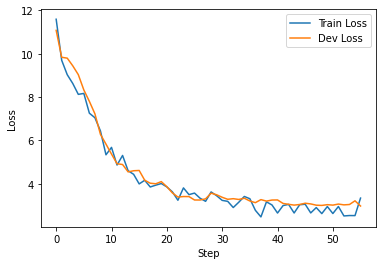

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(dev_losses, label="Dev Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 새 섹션

## Datasets

In [28]:
test_dataset = TokenizedKoMRC.load('/content/test.json')
# test_dataset = TokenizedKoMRC.load('./datasets2/test.json')
indexer_test = Indexer(list(tokenizer.vocab.keys()))
indexed_test_dataset = IndexerWrappedDataset(test_dataset, indexer_test)
print("Number of Test Samples", len(test_dataset))
# print(test_dataset[0])

Number of Test Samples 4008


## Model

In [29]:
best_model[0]

0

In [30]:
best_model

(0, 2.835710230626558)

In [31]:
model = AutoModelForQuestionAnswering.from_pretrained(f'models/{args.NAME}_{best_model[0]}')
model.cuda();
print(f'models/{args.NAME}_{best_model[0]}')
# summary(model, (args.batch_size.train//args.accumulate, args.max_length), dtypes=['torch.IntTensor'], device='cpu')

models/kobigbird_ep1_max2048_lr6e-05_406_0


In [34]:
for idx, sample in zip(range(1, 2), indexed_train_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])

    print('input_ids', sample['input_ids'])
    print('token_type_ids', sample['token_type_ids'])

    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]

    print('t_input_ids', input_ids)
    print('t_token_type_ids', token_type_ids)

    print('input_ids=input_ids[None, :]', input_ids[None, :])
    print('token_type_ids[None, :]', token_type_ids[None, :])

    
    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

    print('output', output)
    print('start_logits', output.start_logits)
    print('end_logits', output.end_logits)


    start_logits = output.start_logits
    end_logits = output.end_logits
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    print('start_logits.squeeze_(0)', start_logits.squeeze_(0))
    print('end_logits.squeeze_(0)', end_logits.squeeze_(0))
    print('token_type_ids.bool()', token_type_ids.bool())
    print('start_logits[token_type_ids.bool()][1:-1]', start_logits[token_type_ids.bool()][1:-1])
    print('start_logits[token_type_ids.bool()][1:-1].softmax(-1)', start_logits[token_type_ids.bool()][1:-1].softmax(-1))


    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

    print('start_prob[:, None]', start_prob[:, None])
    print('end_prob[None, :]', end_prob[None, :])


    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

    print('probability', probability)
    print('torch.argmax(probability)', torch.argmax(probability))

    index = torch.argmax(probability).item()
    print('index', index)

    print('len(end_prob)', len(end_prob))
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    print('start', start)
    print('end', start)
    
    
    start_str = sample['position'][start][0]
    end_str = sample['position'][end][1]

    print('Answer:', sample['context'][start_str:end_str])

------1------
Context: 스기타 겐파쿠는 빠른 판단력을 가진 의사였지만 네덜란드어 실력은 없었다. 역시 타펠 아나토미아를 보고있었고 네덜란드어를 초보수준으로 알고있던 의사 마에노 료타쿠, 동향의 후배 의사 나카가와 쥰안과 의기투합하여 번역을 결의한 것이 1771년이었다. 그들은 사형수의 시체해부 광경을 보고 타펠 아나토미아의 해부도가 정확하다는 것을 확인한 뒤 번역을 결정했다. 번역의 리더는 연장자이자 네덜란드어를 알고있던 마에노 료타쿠였다.nn글을 모르는 그들은 먼저 도판에 주목했다. 도판에 있는 단어들과 인체의 위치를 이용해, 그 단어들이 무엇을 뜻하는지를 추리하듯 찾아나갔다. 그리고 문법적인 요소는 확인이 어렵기 때문에 모르는 채로 넘어갔다. 마지막으로 추상적인 어휘들은 유추를 통해 의미를 파악했다. 예를들어 '코는 후루헷헨도'다. '나뭇가지를 잘라 쌓으면 후루헷헨도', '마당을 쓸면 먼지가 쌓여 후루헷헨도'라는 설명을 어설픈 사전이나 어휘집에서 발견하여 '후루헷헨도'의 의미를 솟아오르다, 봉긋하다(堆)로 정하는 식이었다.nn그리고 모두 번역하는 것이 힘들어서 먼저 도판을 그리고 나중에 본문을 번역했고, 각주는 후일로 미뤄두었다. 마찬가지로 사람들의 반응도 보기위해 도판을 먼저 '해체약도'(1773)라는 이름으로 간행했다. 이것은 소비자의 반응을 보기 위함과 막부의 반응을 보기 위한 두가지 목적이 있었다. 여기서 별 문제가 없었기 때문에 이후 해체신서 전체를 간행하는데 그러면서도 책을 막부에게 헌상하여 이후 문제가 될 소지를 막았으며 이는 전적으로 스기타 겐파쿠의 생각이었다.nn해체신서의 주된 번역자는 마에노 료타쿠였지만 그는 완벽하지 않은 번역이라 하여 번역자로 이름 올리길 거절하였다. 겐파쿠는 급한 마음에 출간에 목표를 두었지만 료타쿠는 천성이 차분한 학자여서 그러한 방식을 선호하지 않았으며 결국 료타쿠 대신 겐파쿠가 대표 저자로 알려지게 되었다. 료타쿠는 책의 서문을 대신 써줄 통역사 요시오 고자에몬(吉雄幸左衛門)에게 직접 부탁하여 

## Evaluate

In [ ]:
for i in range(10):
  start_visualize = []
  end_visualize = []

  with torch.no_grad(), open(f'submissions/{args.NAME}.csv', 'w') as fd:
      writer = csv.writer(fd)
      writer.writerow(['Id', 'Predicted'])

      rows = []
      c = 0
      # for sample in tqdm(test_dataset, "Testing"):
      for sample in tqdm(indexed_test_dataset, "Testing"):
          input_ids, token_type_ids = [torch.tensor(sample[key], dtype=torch.long, device="cuda") for key in ("input_ids", "token_type_ids")]
          # print(sample)
      
          model.eval()
          with torch.no_grad():
              output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

          start_logits = output.start_logits
          end_logits = output.end_logits
          start_logits.squeeze_(0), end_logits.squeeze_(0)

          start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
          end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

          probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

          # 토큰 길이 8까지만
          for row in range(len(start_prob) - 8):
              probability[row] = torch.cat((probability[row][:8+row].cpu(), torch.Tensor([0] * (len(start_prob)-(8+row))).cpu()), 0)

          index = torch.argmax(probability).item()

          start = index // len(end_prob)
          end = index % len(end_prob)
          
          # 확률 너무 낮으면 자르기
          if start_prob[start] > 0.3 and end_prob[end] > 0.3:
              start_str = sample['position'][start][0]
              end_str = sample['position'][end][1]
          else:
              start_str = 0
              end_str = 0

          start_visualize.append((list(start_prob.cpu()), (start, end), (start_str, end_str)))
          end_visualize.append((list(end_prob.cpu()), (start, end), (start_str, end_str)))
          
          rows.append([sample["guid"], sample['context'][start_str:end_str]])

      # writer.writerows(rows)

Testing:   0%|          | 0/4008 [00:00<?, ?it/s]

## Visualize Evaluation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


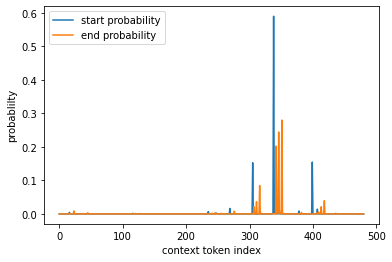

token position: (338, 342)
context position: (0, 0)


In [ ]:
idx = 0

start_visualize = np.array(start_visualize)
end_visualize = np.array(end_visualize)

start_probalilities, token_pos, str_pos = start_visualize[:,0], start_visualize[:,1], start_visualize[:,2]
end_probalilities, token_pos, str_pos = end_visualize[:,0], end_visualize[:,1], end_visualize[:,2]

plt.plot(start_probalilities[idx], label="start probability")
plt.plot(end_probalilities[idx], label="end probability")
plt.xlabel("context token index")
plt.ylabel("probablilty")
plt.legend()
plt.show()

print('token position:', token_pos[idx])
print('context position:', str_pos[idx])

2 281 285


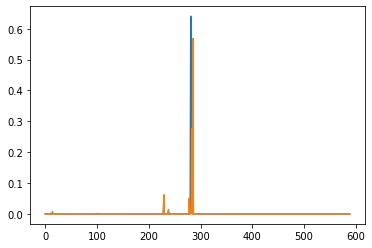

In [ ]:
for i, (start, end) in enumerate(token_pos):
    if end - start > 1:
        if i > 0:
            plt.plot(start_probalilities[i])
            plt.plot(end_probalilities[i])
            print(i, start, end)
            break

2.0918163672654693


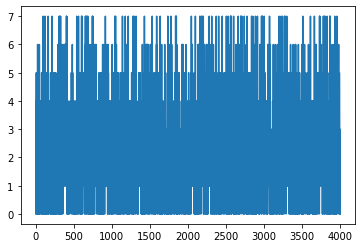

In [ ]:
temp = []
h = 0
l = 100
for i, (start, end) in enumerate(token_pos):
    h = max(h, end - start)
    l = min(l ,end - start)
    temp.append(end - start)
plt.plot(temp)
print(mean(temp))

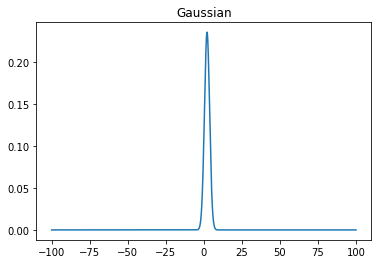

In [ ]:
mu = mean(temp)
sigma = math.sqrt(np.var(temp))
x = np.linspace(-100, 100, len(temp))
g = (1 / np.sqrt(2*np.pi * sigma**2)) * np.exp(- (x-mu)**2 / (2*sigma**2))
plt.title('Gaussian')
plt.plot(x, g)

In [ ]:
z = [(i-mu)/sigma for i in temp]
print(f'평균: {round(mean(z), 9)}')
print(f'표준편차: {math.sqrt(np.var(z))}')
print('-----90%------')
print(mu - 1.645*sigma/math.sqrt(len(temp)))
print(mu + 1.645*sigma/math.sqrt(len(temp)))
print('-----95%------')
print(mu - 1.96*sigma/math.sqrt(len(temp)))
print(mu + 1.96*sigma/math.sqrt(len(temp)))
print('-----99%------')
print(mu - 2.576*sigma/math.sqrt(len(temp)))
print(mu + 2.576*sigma/math.sqrt(len(temp)))

평균: -0.0
표준편차: 0.9999999999999999
-----90%------
2.047882785833475
2.1357499486974634
-----95%------
2.0394699723677743
2.1441627621631643
-----99%------
2.02301824825707
2.1606144862738685


In [ ]:
def read_dev_klue(path):
    with open(path, 'rb') as f:
        klue_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in tqdm(klue_dict['data']):
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                temp_answer = []
                for answer in qa['answers']:
                    temp_answer.append(answer['text'])
                if len(temp_answer) != 0: # answers의 길이가 0 == 답변할 수 없는 질문
                    contexts.append(context)
                    questions.append(question)
                    answers.append(temp_answer)

    return contexts, questions, answers

In [ ]:
dev_contexts, dev_questions, dev_answers = read_dev_klue("/content/klue-mrc-v1.1_dev.json")

  0%|          | 0/5075 [00:00<?, ?it/s]

In [ ]:
def prediction(contexts, questions):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    model.to(device)
    model.eval()
    
    result = []
    
    with torch.no_grad():
        for context, question in zip(contexts, questions):
            encodings = tokenizer(context, question, max_length=512, truncation=True,
                                     padding="max_length", return_token_type_ids=False)
            encodings = {key: torch.tensor([val]) for key, val in encodings.items()}
            
            input_ids = encodings["input_ids"].to(device)
            attention_mask = encodings["attention_mask"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            start_logits, end_logits = outputs.start_logits, outputs.end_logits
            token_start_index, token_end_index = start_logits.argmax(dim=-1), end_logits.argmax(dim=-1)
            pred_ids = input_ids[0][token_start_index: token_end_index + 1]
            pred = tokenizer.decode(pred_ids)
            result.append(pred)

    return result

In [ ]:
pred_answers = prediction(dev_contexts, dev_questions)
pred_answers

['말라카이트',
 '?',
 '5위',
 '5위',
 '?',
 '?',
 '',
 '?',
 '실리콘유로 만들기 위해 거치는 과정',
 '어디',
 '제품 수',
 '',
 '?',
 '16일',
 '?',
 '성서를 영어로 번역한 인물에게 영향을 받은 사람은?',
 '',
 '8호선 역',
 '',
 '한국예술영재교육원',
 '허벅지까지 내려오는 미들 기장의 다운 자켓',
 '어느 섬',
 '시장의 국적은?',
 '친구의 아내에게 함께 복수하기를 부탁하며 무엇',
 '',
 '',
 '',
 '현생 양서류의 호흡방식을 이용해 몸 밖으로 내보낼 수 있는 것은?',
 '',
 '무엇이라고',
 '무엇인가?',
 '',
 '남산 전망을 구경할 수 있는 아파트 이름은?',
 '무엇',
 '?',
 '',
 '올해보다 얼마나',
 '독일의 선거가 시작되는날',
 '어디',
 '어느 나라',
 '',
 '튀코 브라헤',
 '어디',
 '아리스타르코스',
 '?',
 '몇 편',
 '단순포진 각막염의 흰색 병변은 심한 경우에 무엇을 일으키나요?',
 '',
 '얼마',
 '교황청의 세력',
 '견과류',
 '어떤 호르몬을 투여하는 것',
 '?',
 '지구상의 연방군이 쓸 수 없게 된 것',
 '화학무기',
 '군함',
 '?',
 '붉은 혜성이라 부르는 인물',
 '',
 '코오롱프로세스시스템의 지분 절반 이상을 가지고 있는 회사는 어디인가?',
 '한국관광공사 소속 직원',
 '?',
 '?',
 '몇 개인',
 '무담보 대출금액',
 '',
 '?',
 '몇년도',
 '',
 '?',
 '어디',
 '물질',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '',
 '22일 발표된 내용의 조사 마감일',
 '?',
 '',
 '?',
 '',
 '얼마',
 '코나아이에서 스마트카드 개발팀장으로 근무했던 사람의 이름은?',
 '살던 곳',
 '몇 단계',
 '디오게네스는 누구',
 '',
 '일제강점기',
 '고종 황제를 폐위시킨 이후

In [ ]:
def em_evalutate(prediction_answers, real_answers):
    total = len(prediction_answers)
    exact_match = 0
    for prediction_answer, real_answer in zip(prediction_answers, real_answers):
        if prediction_answer in real_answer:
            exact_match += 1
    
    return (exact_match/total) * 100

In [ ]:
em_score = em_evalutate(pred_answers, dev_answers)
em_score

0.024950099800399198